<a href="https://colab.research.google.com/github/AvivBGU/DeepLearning_Assignment2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODOS:
1. Create a proper training setup and embed the stuff implemented in the data loaded to the relevant functions.
2. Make sure that loss and iterations, as well as general data is printed.
3. Have a testing setup for an arbitrary model.
4. Create a model factory to properly balance different parameters of the network.
5. Make sure that the testing setup allows the display of images to have visual verifacation.

# Imports & Constants

<font size="4">Imports </font>

Install Pytorch

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

In [ ]:
import torch
import os
import torch.nn as nn
import zipfile
import requests
import numpy as np
import torch.utils.data as data
import time
from glob import glob
from PIL import Image

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

print("Using torch", torch.__version__)

<font size="4">Constants</font>

In [ ]:
current_working_directory = os.getcwd()
DATA_BASE_DIRECTORY: str = os.path.join(current_working_directory, 'data')
TRAINING_SET_URL='https://web.archive.org/web/20241214060505/https://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt'
TEST_SET_URL='https://web.archive.org/web/20241214070147/https://vis-www.cs.umass.edu/lfw/pairsDevTest.txt#expand'
MAX_PIXEL_VALUE: float = 255.0
IMAGE_SIZE: tuple[int, int] = (250, 250)
BATCH_SIZE: int = 8
IMAGE_MODE: str = 'L' # If the image is greyscale
DEVICE_TO_USE: str = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {DEVICE_TO_USE}')

# Acquiring & Handling Data

<font size="6">Acquiring_Data</font>

In [ ]:
# TODO Refine this mechanism to use python natively.

!pip install -q gdown

def download_images_from_drive(file_id: str, zip_path: str) -> str:
  """
  Downloads images from drive and return the path to the extracted folder, but 1
  level down assuming the structure of the directories are known in advance.
  """
  file_location: str = os.path.join(DATA_BASE_DIRECTORY, 'lfw2', 'lfw2')
  if os.path.exists(file_location):
    print(f"Dataset already downloaded to {file_location}")
    return file_location
  
  !gdown {file_id} -O {zip_path}

  os.makedirs(DATA_BASE_DIRECTORY, exist_ok=True)
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(DATA_BASE_DIRECTORY)
  !rm {zip_path}
  print(f"Dataset extracted to {DATA_BASE_DIRECTORY}")
  return file_location

updated_dir_location: str = download_images_from_drive(
    file_id="1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp",
    zip_path="dataset.zip"
    )

<font size="4">Preprocessing function</font>

<font size="4">Loading file paths to memory</font>

In [ ]:
def loads_files_paths_to_memory(base_directory: str, image_format: str = '.jpg') -> None:
    images: dict[str, dict[int, str]] = dict()
    images_loaded: int = 0
    for root, subdirs, files in os.walk(base_directory):
        if root == base_directory:
            continue
        person_name: str = root.split(os.sep)[-1]
        if person_name not in images:
            images[person_name] = dict()
        for file in files:
            if not file.endswith(image_format):
                raise Warning(f"File {file} is not a {image_format} file. Continuing...")
                continue
            stripped_image: str = file.rstrip(image_format) # File without ending
            image_index: int = int(stripped_image.split('_')[-1])
            if image_index in images[person_name]:
                 raise ValueError(f"Index: {image_index} collision for: {person_name}")
            images[person_name][image_index] = os.path.join(root, file)
            images_loaded += 1
    if len(images) < 1:
        raise ValueError(f"No images were found in {base_directory}, aborting...")
    print(f"People scanned: {len(images)}")
    print(f"Images loaded: {images_loaded}")
    return images

loaded_images: dict[str, dict[str, str]] = loads_files_paths_to_memory(updated_dir_location)

<font size="4">Organizing According to train-test</font>

Get train-test division and parse it.

In [ ]:
def parse_train_test_txt(url_to_use: str):
    url_response = requests.get(url_to_use)
    if url_response.status_code == 200:
        text_content = url_response.text
    else:
        raise ValueError("Invalid URL")
    ret_text: list[str] = text_content.split('\n')
    examples: list[tuple[tuple[str, int], tuple[str, int], bool]] = list()
    for text in ret_text:
        separated_by_tabs: list[str] = text.split('\t')
        if len(separated_by_tabs) < 3:
            # This is the number in the beginning
            continue
        if len(separated_by_tabs) == 3:
            # This is a positive example (2 Pictures of the same person)
            person = separated_by_tabs[0]
            first_image_index = int(separated_by_tabs[1])
            second_image_index = int(separated_by_tabs[2])
            examples.append(
                                        (
                                             (person, first_image_index),
                                             (person, second_image_index),
                                             1
                                        )
                                     )
        if len(separated_by_tabs) == 4:
            first_person = separated_by_tabs[0]
            first_person_image_index = int(separated_by_tabs[1])
            second_person = separated_by_tabs[2]
            second_person_image_index = int(separated_by_tabs[3])
            examples.append(
                                        (
                                             (first_person, first_person_image_index),
                                             (second_person, second_person_image_index),
                                             0
                                        )
                                     )
    return examples

training_examples = parse_train_test_txt(TRAINING_SET_URL)
test_examples = parse_train_test_txt(TEST_SET_URL)

In [ ]:
def load_images(images_file_paths_dict: dict[str, dict[int, str]],
                examples_list: list[tuple[tuple[str, int], tuple[str, int], bool]]) -> list[tuple[Image.Image, Image.Image]]:
  """
  Loads the images given to memory in the following format:
  Returns 2 lists:
  list[loaded_image, loaded_image], list[is_same]
  """
  data_to_ret: list = list()
  labels_to_ret: list[bool] = list() # Returned labels, true if same person, false otherwise.
  for example in examples_list:
    first_person, first_image_index = example[0]
    second_person, second_image_index = example[1]
    is_same = example[2]
    first_image_path = images_file_paths_dict[first_person][first_image_index]
    second_image_path = images_file_paths_dict[second_person][second_image_index]
    first_image = Image.open(first_image_path)
    second_image = Image.open(second_image_path)
    if (first_image.mode != IMAGE_MODE) or (second_image.mode != IMAGE_MODE):
        raise ValueError("Images have different modes.")
    if (first_image.size != IMAGE_SIZE) or (second_image.size != IMAGE_SIZE):
        raise ValueError("Images have different sizes.")
    data_to_ret.append((first_image, second_image))
    labels_to_ret.append(is_same)
  return data_to_ret, labels_to_ret

training_data, training_labels = load_images(loaded_images, training_examples)
test_data, test_labels = load_images(loaded_images, test_examples)

In [ ]:
def convert_images_to_array(image_tuple_list: list[tuple[Image.Image, Image.Image]]) -> list[np.ndarray]:
  returned_list: list[np.ndarray] = list()
  for first_image, second_image in image_tuple_list:
    normalized_first_image = np.array(first_image) / MAX_PIXEL_VALUE
    normalized_second_image = np.array(second_image) / MAX_PIXEL_VALUE
    first_image_array = np.array(normalized_first_image)
    second_image_array = np.array(normalized_second_image)
    returned_list.append((first_image_array, second_image_array))
  return returned_list

arrayed_training_data = convert_images_to_array(training_data)
arrayed_test_data = convert_images_to_array(test_data)

In [ ]:
class SiameseDataset(data.Dataset):
    def __init__(self, image_pairs: list[tuple], labels: list[int]):
        self.image_pairs = image_pairs
        self.labels = labels

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img1, img2 = self.image_pairs[idx]
        img1 = torch.tensor(np.array(img1), dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        img2 = torch.tensor(np.array(img2), dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img1, img2, label

training_dataset: data.Dataset = SiameseDataset(arrayed_training_data, training_labels)
test_dataset: data.Dataset = SiameseDataset(arrayed_test_data, test_labels)
training_loader: data.DataLoader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader: data.DataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)


# Neural Network definition and stuff

<font size="6">Creating Network</font>

In [ ]:
class ModularSiameseNetwork(nn.Module):
    def __init__(self,
                 first_conv_layer: tuple[int, int, int, bool],
                 other_layers: list[(int, int, bool)],
                 input_size: list[int, int, int], # channels, height, width
                 fully_connected_layer_size: int,
                 random_weight_seed: int = 42):
        """
        First_conv_layer: [in_channels, out_channels, kernel_size, should use pooling]
        other_layers [(out_channels, kernel_size, should_use_pooling)]
        """
        super().__init__()
        torch.manual_seed(random_weight_seed)

        self.main_network_block = nn.Sequential()
        first_layer_in_channel, first_layer_out_channel, first_layer_kernel_size, first_layer_use_max_pool = first_conv_layer
        self.main_network_block.append(
            nn.Conv2d(in_channels=first_layer_in_channel,
                      out_channels=first_layer_out_channel,
                      kernel_size=first_layer_kernel_size)
        )
        self.main_network_block.append(
            nn.ReLU(inplace=True),
        )
        if first_layer_use_max_pool:
            self.main_network_block.append(
                nn.MaxPool2d(2)
            )
        prev_layer_output: int = first_layer_out_channel
        for current_layer in other_layers:
            current_layer_output_channels, current_layer_kernel_size, use_max_pool = current_layer
            self.main_network_block.append(
                nn.Conv2d(prev_layer_output,
                          current_layer_output_channels,
                          kernel_size=current_layer_kernel_size)
            )
            self.main_network_block.append(
                nn.ReLU(inplace=True)
            )
            if use_max_pool: # If maxpooling should be used.
              self.main_network_block.append(
                  nn.MaxPool2d(2)
              )
            prev_layer_output = current_layer_output_channels

        with torch.no_grad(): # Dynamically calculate the size of the layer according to expected input.
            dummy = torch.zeros(1, *input_size)
            dummy_out = self.main_network_block(dummy)
            flattened_size = dummy_out.view(1, -1).size(1)

        self.fully_connected_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, fully_connected_layer_size),
            nn.Sigmoid()
        )

        self.output_layer = nn.Sequential(
            nn.Linear(fully_connected_layer_size, 1),
            nn.Sigmoid()
        )

        # === Initialization ===
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=1e-2)
                nn.init.normal_(m.bias, mean=0.5, std=1e-2)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=2e-1)
                nn.init.normal_(m.bias, mean=0.5, std=1e-2)

    def forward_once(self, input):
        network_block_output = self.main_network_block(input)
        fully_connected_layer_output = self.fully_connected_layer(network_block_output)
        return fully_connected_layer_output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return self.output_layer(torch.abs(output1 - output2)) # L1 distance.

<font size="6">Loss & Optimizer</font>

In [ ]:
class RegularizedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, model, lambda_reg=1e-4):
        super().__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.bce = nn.BCELoss()

    def forward(self, outputs, targets):
        loss = self.bce(outputs, targets)
        reg_loss = 0.0
        for param in self.model.parameters():
            if param.requires_grad:
                reg_loss += torch.sum(param ** 2)
        total_loss = loss + self.lambda_reg * reg_loss
        return total_loss


<font size="6">Network initialization</font>

In [28]:
model = ModularSiameseNetwork(
    first_conv_layer=(1, 32, 10, True),
    other_layers=[(64, 7, True),
                  (64, 4, True), 
                  (128, 4, False)],
    input_size=[1, 250, 250],
    fully_connected_layer_size=4096
)
model_in_gpu = model.to(DEVICE_TO_USE)
criterion = RegularizedBinaryCrossEntropyLoss(model, lambda_reg=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

<font size="6">Network training</font>

In [29]:
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()
    model_in_gpu.train()
    running_loss = 0.0

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    for batch_idx, (input1, input2, targets) in enumerate(training_loader):
        torch.cuda.empty_cache()
        input1, input2, targets = \
            input1.to(DEVICE_TO_USE, non_blocking=True), \
            input2.to(DEVICE_TO_USE, non_blocking=True), \
            targets.unsqueeze(1).to(DEVICE_TO_USE, non_blocking=True)

        optimizer.zero_grad()
        output = model_in_gpu(input1, input2)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % 2 == 0 or (batch_idx + 1) == len(training_loader):
            print(f"  Batch [{batch_idx+1}/{len(training_loader)}], Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(training_loader)
    elapsed_time = time.time() - start_time
    print(f"Epoch [{epoch+1}] completed in {elapsed_time:.2f}s, Average Loss: {avg_loss:.4f}")

    model_in_gpu.eval()
        


Epoch [1/10]
  Batch [2/275], Loss: 1121.1482
  Batch [4/275], Loss: 961.1873
  Batch [6/275], Loss: 818.0040
  Batch [8/275], Loss: 695.1710
  Batch [10/275], Loss: 587.4221
  Batch [12/275], Loss: 497.2154
  Batch [14/275], Loss: 420.7846
  Batch [16/275], Loss: 354.4915
  Batch [18/275], Loss: 299.2043
  Batch [20/275], Loss: 252.3764
  Batch [22/275], Loss: 212.8928
  Batch [24/275], Loss: 181.5539
  Batch [26/275], Loss: 154.2483
  Batch [28/275], Loss: 132.7019
  Batch [30/275], Loss: 111.4328
  Batch [32/275], Loss: 96.3894
  Batch [34/275], Loss: 82.6726
  Batch [36/275], Loss: 72.5062
  Batch [38/275], Loss: 63.9200
  Batch [40/275], Loss: 54.7697
  Batch [42/275], Loss: 49.4879
  Batch [44/275], Loss: 43.0506
  Batch [46/275], Loss: 38.4942
  Batch [48/275], Loss: 34.1365
  Batch [50/275], Loss: 31.0463
  Batch [52/275], Loss: 28.5816
  Batch [54/275], Loss: 27.9635
  Batch [56/275], Loss: 25.1742
  Batch [58/275], Loss: 23.4732
  Batch [60/275], Loss: 21.5344
  Batch [62/27

KeyboardInterrupt: 

<font size="6">Evaluation</font>

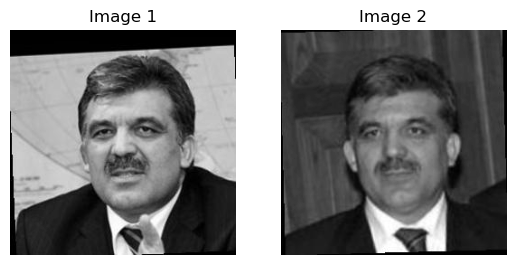

prediction: tensor([[0.4865]], device='cuda:0')
expected result: 1.0


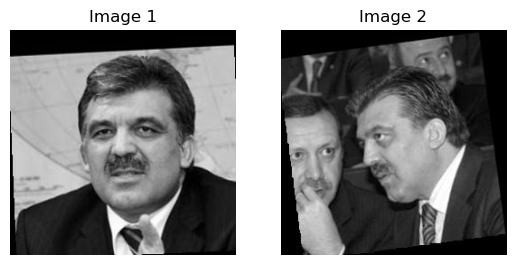

prediction: tensor([[0.5311]], device='cuda:0')
expected result: 1.0


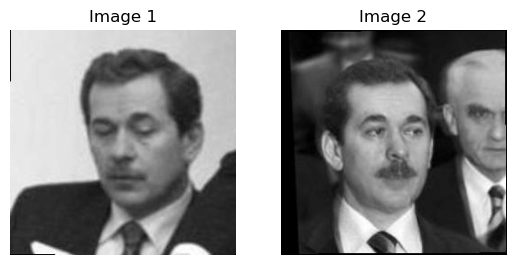

prediction: tensor([[0.5114]], device='cuda:0')
expected result: 1.0


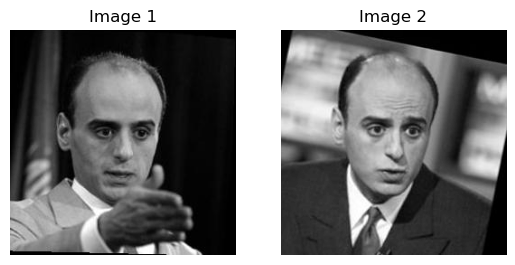

prediction: tensor([[0.4987]], device='cuda:0')
expected result: 1.0


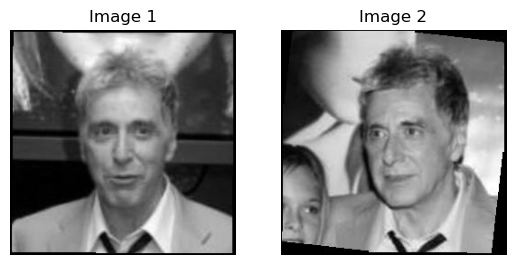

prediction: tensor([[0.5551]], device='cuda:0')
expected result: 1.0


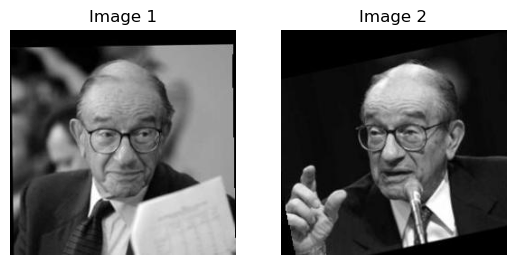

prediction: tensor([[0.5499]], device='cuda:0')
expected result: 1.0


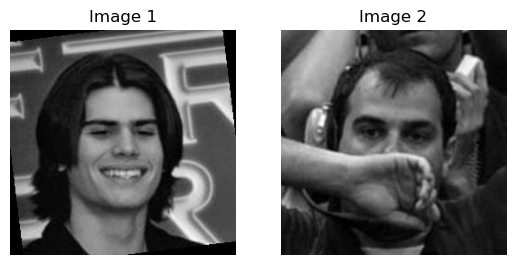

prediction: tensor([[0.5106]], device='cuda:0')
expected result: 0.0


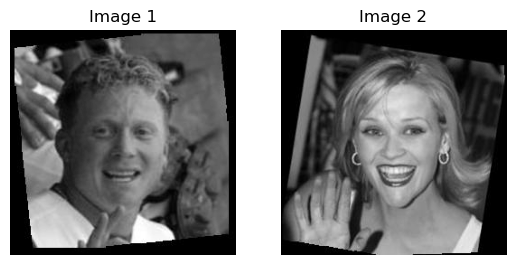

prediction: tensor([[0.6829]], device='cuda:0')
expected result: 0.0


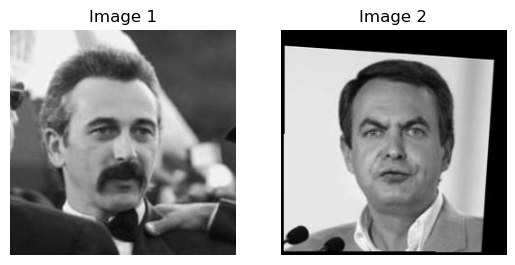

prediction: tensor([[0.5565]], device='cuda:0')
expected result: 0.0


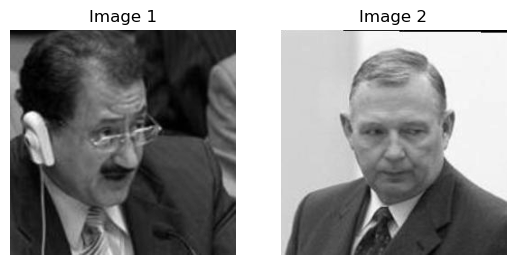

prediction: tensor([[0.4369]], device='cuda:0')
expected result: 0.0


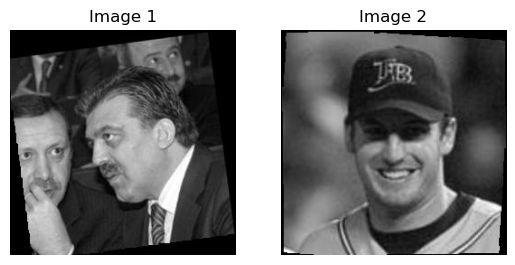

prediction: tensor([[0.6795]], device='cuda:0')
expected result: 0.0


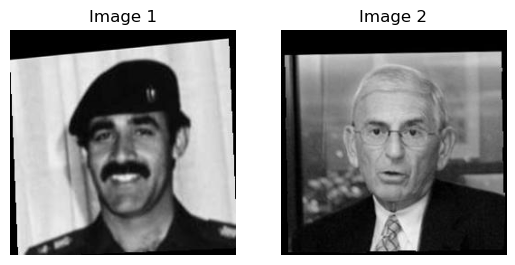

prediction: tensor([[0.5740]], device='cuda:0')
expected result: 0.0
Test Loss: 34.0358, Test Accuracy: 50.00%


In [27]:
import matplotlib.pyplot as plt

# Testing
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

plots_to_open: int = 6
iter_for_same = plots_to_open
iter_for_different = plots_to_open
with torch.no_grad():
    for test_input1, test_input2, test_targets in test_loader:
        test_input1, test_input2, test_targets = \
        test_input1.to(DEVICE_TO_USE, non_blocking=True), \
        test_input2.to(DEVICE_TO_USE, non_blocking=True), \
        test_targets.unsqueeze(1).to(DEVICE_TO_USE, non_blocking=True)


        test_output = model(test_input1, test_input2)

        expected_result = test_targets[0, 0].item()


        if expected_result > 0.9:
            if iter_for_same > 0:

                cpu_input1 = test_input1.cpu()
                cpu_input2 = test_input2.cpu()

                img1_np = cpu_input1[0].squeeze(0).numpy()
                img2_np = cpu_input2[0].squeeze(0).numpy()

                # Plotting
                fig, axs = plt.subplots(1, 2)
                axs[0].imshow(img1_np, cmap='gray')
                axs[0].set_title('Image 1')
                axs[0].axis('off')

                axs[1].imshow(img2_np, cmap='gray')
                axs[1].set_title('Image 2')
                axs[1].axis('off')
                iter_for_same -= 1
                plt.show()
                print(f"prediction: {test_output}")
                print(f"expected result: {expected_result}")
        else:
            if iter_for_different > 0:

                cpu_input1 = test_input1.cpu()
                cpu_input2 = test_input2.cpu()

                img1_np = cpu_input1[0].squeeze(0).numpy()
                img2_np = cpu_input2[0].squeeze(0).numpy()

                # Plotting
                fig, axs = plt.subplots(1, 2)
                axs[0].imshow(img1_np, cmap='gray')
                axs[0].set_title('Image 1')
                axs[0].axis('off')

                axs[1].imshow(img2_np, cmap='gray')
                axs[1].set_title('Image 2')
                axs[1].axis('off')
                iter_for_different -= 1
                plt.show()
                print(f"prediction: {test_output}")
                print(f"expected result: {expected_result}")
        batch_loss = criterion(test_output, test_targets)
        test_loss += batch_loss.item()
        predictions = torch.sigmoid(test_output) > 0.5
        correct = (predictions.float() == test_targets).sum().item()
        correct_predictions += correct
        total_predictions += test_targets.size(0)


test_loss /= len(test_loader)
accuracy = correct_predictions / total_predictions

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")